# Spectral decomposition with kernels

In [1]:
import time
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh

sys.path.append('..')
from weights import NearestNeighbors, KernelComputer, KernelRegressor

np.random.seed(0)

The following command are using LaTeX backend to produce Type 1 font in PDF produced by matplotlib (it produces Type 3 otherwise). You can uncomment those lines.

In [2]:
%matplotlib inline
plt.rcParams['text.latex.preamble'] = [r'\usepackage{newtxmath}'] 
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"
plt.rc('text', usetex=True)

In [3]:
def get_data(nb, d, dist=1):
    x = np.random.randn(nb, d)
    x[::2, 0] += dist
    y = np.ones(nb)
    y[::2] = -1
    return x, y

In [4]:
def get_K(x1, x2, sigma):
    # x1 = xtrain, x2 = xtest
    sigma2 = sigma ** 2
    K = x1 @ x2.T
    K *= 2
    _attr1 = np.sum(x1 ** 2, axis=1)[:, np.newaxis]
    K -= _attr1
    K -= np.sum(x2 ** 2, axis=1)
    K /= 2*sigma2
    np.exp(K, out=K)
    return K


def get_SZ(x1, x2, sigma, SS=None, reshape=True):
    """
    To be written, something of the type
    
    Returns
    -------
    SZ: ndarray
        SZ[i, j*m] = :math:`\partial_{1,m}` k(x1[j], x2[i])
    """
    if SS is None:
        SS = get_K(x1, x2, sigma)
    SZ = np.tile(SS[...,np.newaxis], (1, 1, x1.shape[1]))
    # diff[i,j,k] = x1[i,k] - x2[j,k]
    diff = x1[:, np.newaxis, :] - x2[np.newaxis, ...]
    diff /= sigma**2
    SZ *= diff
    n1, n2, d = SZ.shape

    if reshape:
        # return SZ.reshape(n1, -1, order='F') # slower than the following
        SZ_reshape = np.empty((n1, n2*d), SZ.dtype)
        for i in range(d):
            SZ_reshape[:, i*n2:(i+1)*n2] = SZ[..., i]
        return SZ_reshape
    return SZ


def get_ZZ(x1, x2, sigma, SS=None, reshape=True):
    if SS is None:
        SS = get_K(x1, x2, sigma)
    d = x1.shape[1]
    ZZ = np.tile(SS[...,np.newaxis, np.newaxis], (1, 1, d, d,))
    # diff[i,j,k] = x1[i,k] - x2[j,k]
    diff = x1[:, np.newaxis, :] - x2[np.newaxis, ...]
    # prod_diff[i,j,k,l] = diff[i,j,l]*diff[i,j,k] = (x1[i,l] - x2[j,l]) * (x1[i,k] - x2[j,k])
    prod_diff = diff[:,:, np.newaxis, :]*diff[:,:,:,np.newaxis]
    prod_diff /= sigma**4
    prod_diff *= -1
    for i in range(d):
        prod_diff[:, :, i, i] += 1 / (sigma**2)
    ZZ *= prod_diff
    if reshape:
        # return ZZ.transpose((0, 2, 1, 3)).reshape(n1 * d, n2 * d, order='F') # slower
        n1, n2, = SS.shape
        ZZ_reshape = np.empty((n1*d, n2*d), ZZ.dtype)
        for i in range(d):
            for j in range(i):
                ZZ_reshape[n1*i:n1*(i+1), n2*j:n2*(j+1)] = ZZ[..., i, j]
                ZZ_reshape[n1*j:n1*(j+1), n2*i:n2*(i+1)] = ZZ[..., j, i]
            ZZ_reshape[n1*i:n1*(i+1), n2*i:n2*(i+1)] = ZZ[..., i, i]
        return ZZ_reshape
    return ZZ


def get_ST(x1, x2, sigma, SS=None, SZ=None):
    if SS is None:
        SS = get_K(x1, x2, sigma)
    if SZ is None:
        SZ = get_SZ(x1, x2, sigma, SS)
    n1, n2 = SS.shape
    d = x1.shape[1]
    ST = np.zeros((n1, n2*(d+1)), dtype=np.float)
    ST[:, :n2] = SS
    ST[:, n2:] = SZ
    return ST


def get_TZ(x1, x2, sigma, SZ=None, ZZ=None):
    if SZ is None:
        SZ = get_SZ(x1, x2, sigma)
    if ZZ is None:
        ZZ = get_ZZ(x1, x2, sigma)
    n1, d = x1.shape
    n2 = x2.shape[0]
    TZ = np.zeros((n1*(d+1), n2*d), dtype=np.float)
    TZ[:n1,:] = SZ
    TZ[n1:,:] = ZZ
    return TZ


def get_TT(x1, sigma, SS=None, SZ=None, ZZ=None):
    if SS is None:
        SS = get_K(x1, sigma)
    if SZ is None:
        SZ = get_SZ(x1, sigma)
    if ZZ is None:
        ZZ = get_ZZ(x1, sigma)
    n, d = x1.shape
    TT = np.zeros((n*(d+1), n*(d+1)), dtype=np.float)
    TT[:n, :n] = SS
    TT[:n, n:] = SZ
    TT[n:, :n] = SZ.transpose()
    TT[n:, n:] = ZZ
    return TT

In [5]:
def Laplacian_weights(x_train, sigma=.2, mu=1, 
                      Tikhonov=True, lambd=1, full_matrix=False,
                      k=4, psi=lambda x: (x+1)**(-1),
                      p=None
                     ):
    """Solution with small representation
    
    Parameters
    ----------
    x_train: ndarray
        design matrices of the data of shape (number_data, data_dimension)
    sigma: float
        bandwidth of the Gaussian kernel
    mu: float
        regularizer of the kernel diffusion operator
    Tikhonov: boolean, optional
        specify a call to np.linalg.solve rather than scipy.linalg.eigh
    lambd: float, optional
        value of Tikhonov regularization
    k: int, optional
        number of eigen vector to consider in spectral clutering
    psi: function, optional
        filtering function for spectral clustering
        
    Returns
    -------
    y_pred: ndarray of int
        array of prediction of shape (number_data,)
    """
    n, nl = len(x_train), len(y_train)
    SS = get_K(x_train, x_train, sigma)
    if full_matrix:
        A = SS[:p, ...] @ SS[..., :p]
        A /= n
    else:
        A = SS[:p, :nl] @ SS[:nl, :p]
        A /= nl
    
    SZ = get_SZ(x_train, x_train, sigma, SS)
    B = SZ[:p] @ SZ[:p].transpose()
    B /= n
    B += mu * SS[:p,:p]
    B += 1e-10 * np.eye(B.shape[0])

    b = SS[:p, :nl]
    b /= nl
    
    if Tikhonov:
        c = np.linalg.solve(A + lambd * B, b)
    else:
        v, e = eigh(A, B, subset_by_index = [A.shape[0]-k, A.shape[0]-1])
        c = (e * psi(v)) @ (e.T @ b)
        
    return c
#     return SS[..., :p] @ c

In [6]:
def Laplacian_full_weights(x_train, sigma=.2, mu=1, 
                           Tikhonov=True, lambd=1, full_matrix=False,
                           k=4, psi=lambda x: (x+1)**(-1),
                          ):
    """Solution with small representation
    
    Parameters
    ----------
    x_train: ndarray
        design matrices of the data of shape (number_data, data_dimension)
    sigma: float
        bandwidth of the Gaussian kernel
    mu: float
        regularizer of the kernel diffusion operator
    Tikhonov: boolean, optional
        specify a call to np.linalg.solve rather than scipy.linalg.eigh
    lambd: float, optional
        value of Tikhonov regularization
    k: int, optional
        number of eigen vector to consider in spectral clutering
    psi: function, optional
        filtering function for spectral clustering
        
    Returns
    -------
    y_pred: ndarray of int
        array of prediction of shape (number_data,)
    """
    n, nl = len(x_train), len(y_train)
    SS = get_K(x_train, x_train, sigma)
    SZ = get_SZ(x_train, x_train, sigma, SS)
    ST = get_ST(x_train, x_train, sigma, SS, SZ)
    if full_matrix:
        A = ST.transpose() @ ST
        A /= n
    else:
        A = ST.transpose()[..., :nl] @ ST[:nl]
        A /= nl
    
    ZZ = get_ZZ(x_train, x_train, sigma, SS)
    TZ = get_TZ(x_train, x_train, sigma, SZ, ZZ)
    B = TZ @ TZ.transpose()
    B /= n
    TT = get_TT(x_train, sigma, SS, SZ, ZZ)
    B += mu * TT
    B += 1e-10 * np.eye(B.shape[0])

    b = ST.transpose()[..., :nl]
    b /= nl
    
    if Tikhonov:
        c = np.linalg.solve(A + lambd * B, b)
    else:
        v, e = eigh(A, B, subset_by_index = [A.shape[0]-k, A.shape[0]-1])
        c = (e * psi(v)) @ (e.T @ b)
        
    return c
#     return SS[..., :p] @ c

In [7]:
def graph_weights(x_train, sigma=2e-1):
    # Laplacian matrix
    W = 2 * x_train @ x_train.T
    norm = np.sum(x_train ** 2, axis=1)
    W -= norm[:, np.newaxis]
    W -= norm[np.newaxis, :]
    W /= sigma**2
    W = np.exp(W)
    W -= np.diag(np.sum(W, axis=1))
    
    n_label = len(y_train)
    W[n_label:, n_label:] += 1e-10 * np.eye(len(W) - n_label)
    alpha = np.linalg.solve(W[n_label:, n_label:], W[n_label:, :n_label])
    alpha *= -1
    alpha = np.vstack((np.eye(n_label), alpha))    
    return alpha

In [8]:
dim = 10
dist = 3
n_label = 50
n_train = 5000
# sigma = .1*np.sqrt(dim)
sigma = (np.log(n_train) / n_train) ** (1 / (dim + 4))
# sigma = dim ** (1/5)

# dim = 200
# n_train = 200
# dist = .3*np.sqrt(dim)
# n_label = 50
# sigma = 1*np.sqrt(dim)

# dim = 200
# n_train = 200
# dim = 20
# n_train = 2000
# dist = np.sqrt(dim)
# n_label = 50
# sigma = .1*np.sqrt(dim)

x_train, y_test = get_data(n_train, dim, dist)
n_label = min(n_train, n_label)
y_train = y_test[:n_label]

In [26]:
ns = np.logspace(1, 4, num=5).astype(int)
# ns = [int(10**(3))]
nb_trials = 30
print(ns)

[   10    56   316  1778 10000]


In [9]:
n_train = 1000

In [12]:
n_train = 1000
dim = 10
sigma = np.log(n_train) / (n_train ** (1/(dim+4)))
print(sigma)

4.217462494454697


In [13]:
n_train ** (-1/(dim + 4))

0.6105402296585328

In [27]:
times_k = np.zeros((len(ns), nb_trials))
errors_k = np.zeros((len(ns), nb_trials))
soft_errors_k = np.zeros((len(ns), nb_trials))
times_fk = np.zeros((len(ns), nb_trials))
errors_fk = np.zeros((len(ns), nb_trials))
soft_errors_fk = np.zeros((len(ns), nb_trials))
times_g = np.zeros((len(ns), nb_trials))
errors_g = np.zeros((len(ns), nb_trials))
soft_errors_g = np.zeros((len(ns), nb_trials))
for i, n_train in enumerate(ns):
    print(n_train)
    n_label = int(n_train / 10)
    for trial in range(nb_trials):

        x_train, y_test = get_data(n_train, dim, dist)
        n_label = min(n_train, n_label)
        y_train = y_test[:n_label]

        p = 50
        sigma = np.log10(n_train) / (n_train ** (1/(dim+4)))

        t = time.time()
        c_kernel = Laplacian_weights(x_train, mu=1/n_train, sigma=sigma, Tikhonov=True, lambd=1, p=p)
        t_k = time.time() - t
        SS = get_K(x_train, x_train, sigma=sigma)
        c_k = SS[...,:p] @ c_kernel
        y_soft = c_k @ y_train
        y_pred_k = np.sign(y_soft)

        error_k = (y_pred_k != y_test).mean()
        soft_error_k = ((y_soft - y_test) ** 2).mean()

#         t = time.time()
#         c_fk = Laplacian_full_weights(x_train, mu=1/n_train, sigma=sigma, Tikhonov=True, lambd=1, full_matrix=True)
#         t_fk = time.time() - t
#         ST = get_ST(x_train, x_train, sigma=sigma)
#         c_fk = ST @ c_fk
#         y_soft = c_fk @ y_train
#         y_pred_fk = np.sign(y_soft)

#         error_fk = (y_pred_fk != y_test).mean()
#         soft_error_fk = ((y_soft - y_test) ** 2).mean()
        
        # Graph-based
#         sigma = (np.log(n_train) / n_train) ** (1 / (dim + 4))

        t = time.time()
        c_g = graph_weights(x_train, sigma=sigma)
        c_g /= np.abs(c_g).sum(axis=1)[:, np.newaxis]
        t_g = time.time() - t

        y_soft = c_g @ y_train
        y_pred_g = np.sign(y_soft)

        error_g = (y_pred_g != y_test).mean()
        soft_error_g = ((y_soft - y_test) ** 2).mean()

        times_k[i,trial] = t_k 
        errors_k[i,trial] = error_k
        soft_errors_k[i,trial] = soft_error_k
#         times_fk[i,trial] = t_fk 
#         errors_fk[i,trial] = error_fk
#         soft_errors_fk[i,trial] = soft_error_fk
        times_g[i,trial] = t_g
        errors_g[i,trial] = error_g
        soft_errors_g[i,trial] = soft_error_g

10
56
316
1778
10000


KeyboardInterrupt: 

In [28]:
trial

2

In [38]:
errors_g

array([[0.5       , 0.6       , 0.6       , 0.5       , 0.4       ,
        0.4       , 0.4       , 0.3       , 0.6       , 0.5       ,
        0.6       , 0.5       , 0.6       , 0.2       , 0.1       ,
        0.6       , 0.3       , 0.2       , 0.5       , 0.5       ,
        0.7       , 0.4       , 0.4       , 0.3       , 0.2       ,
        0.4       , 0.5       , 0.5       , 0.5       , 0.5       ],
       [0.42857143, 0.03571429, 0.125     , 0.25      , 0.16071429,
        0.46428571, 0.14285714, 0.125     , 0.39285714, 0.41071429,
        0.125     , 0.41071429, 0.42857143, 0.19642857, 0.28571429,
        0.08928571, 0.14285714, 0.41071429, 0.05357143, 0.26785714,
        0.08928571, 0.44642857, 0.42857143, 0.46428571, 0.21428571,
        0.14285714, 0.42857143, 0.25      , 0.42857143, 0.48214286],
       [0.06962025, 0.4335443 , 0.09177215, 0.07594937, 0.06012658,
        0.14240506, 0.25632911, 0.06012658, 0.09177215, 0.08860759,
        0.32594937, 0.07278481, 0.12974684, 0.

In [19]:
ind = np.array([True, False, True, True, True,
                True, True, True, True, True,
                True, True, True, True, True,
                True, True, True, False, False,
               ])

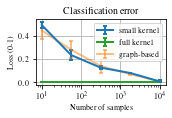

In [34]:
fig, ax = plt.subplots(figsize=(2.5, 1.75))
ax.set_xscale("log")
b = ax.errorbar(ns, errors_g.mean(axis=1), .5*errors_g.std(axis=1), capsize=2, linewidth=2, capthick=2, color='C1', alpha=.5)
c = ax.errorbar(ns, errors_fk.mean(axis=1), .5*errors_fk.std(axis=1), capsize=2, linewidth=2, capthick=2, color='C2', alpha=1)
a = ax.errorbar(ns, errors_k.mean(axis=1), .5*errors_k.std(axis=1), capsize=2, linewidth=2, capthick=2, color='C0', alpha=1)
ax.legend([a, c, b], ['small kernel', 'full kernel', 'graph-based'], prop={'size':8}, ncol=1, loc='upper right')
# ax.legend([a, b], ['kernelized', 'graph-based'], prop={'size':8}, ncol=1, loc='upper right')
ax.grid()
ax.set_title(r'Classification error', size=10)
ax.set_ylabel(r'Loss (0-1)', size=8)
# ax.set_yticks([])
# ax.set_ylim(0, .7)
ax.set_xlabel(r'Number of samples', size=8)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
# fig.savefig('savings/classification_error.pdf')#, facecolor='k', transparent=False)

In [35]:
ind = np.array([True, False, True, True, True,
                True, True, True, True, True,
                True, True, True, True, True,
                True, True, True, False, False,
               ])

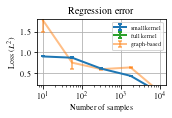

In [36]:
fig, ax = plt.subplots(figsize=(2.5, 1.75))
ax.set_xscale("log")
b = ax.errorbar(ns, soft_errors_g.mean(axis=1), .5*soft_errors_g.std(axis=1), capsize=2, linewidth=2, capthick=2, color='C1', alpha=.5)
c = ax.errorbar(ns, soft_errors_fk.mean(axis=1), .5*soft_errors_fk.std(axis=1), capsize=2, linewidth=2, capthick=2, color='C2', alpha=1)
a = ax.errorbar(ns, soft_errors_k.mean(axis=1), .5*soft_errors_k.std(axis=1), capsize=2, linewidth=2, capthick=2, color='C0', alpha=1)
# ax.legend([a, b], ['kernelized', 'graph-based'], prop={'size':8}, ncol=1, loc='upper right')
ax.legend([a, c, b], ['small kernel', 'full kernel', 'graph-based'], prop={'size':6}, ncol=1, loc='upper right')
ax.grid()
ax.set_title(r'Regression error', size=10)
ax.set_ylabel(r'Loss ($L^2$)', size=8)
# ax.set_yticks([])
ax.set_ylim(0.2, 1.8)
ax.set_xlabel(r'Number of samples', size=8)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
# fig.savefig('savings/regression_error.pdf')#, facecolor='k', transparent=False)

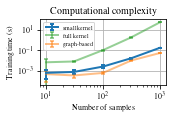

In [86]:
fig, ax = plt.subplots(figsize=(2.5, 1.75))
ax.set_yscale('log')
ax.set_xscale('log')
b = ax.errorbar((ns), times_g.mean(axis=1), .5*times_g.std(axis=1), capsize=2, linewidth=2, capthick=2, color='C1', alpha=.5)
c = ax.errorbar((ns), times_fk.mean(axis=1), .5*times_fk.std(axis=1), capsize=2, linewidth=2, capthick=2, color='C2', alpha=.5)
a = ax.errorbar((ns), times_k.mean(axis=1), .5*times_k.std(axis=1), capsize=2, linewidth=2, capthick=2, color='C0', alpha=1)
ax.legend([a, c, b], ['small kernel', 'full kernel', 'graph-based'], prop={'size':6}, ncol=1, loc='upper left')
ax.grid()
ax.set_title(r'Computational complexity', size=10)
ax.set_ylabel(r'Training time (s)', size=8)
# ax.set_yticks([])
ax.set_xlabel(r'Number of samples', size=8)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
# fig.savefig('savings/computation_time.pdf')#, facecolor='k', transparent=False)

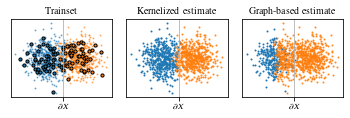

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5, 1.75))
ind = y_test == 1
ax1.scatter(x_train[ind, 0], x_train[ind, 1], c='C0', s=1, alpha=.5)
ax1.scatter(x_train[~ind, 0], x_train[~ind, 1], c='C1', s=1, alpha=.5)
ind = y_train == 1
ax1.scatter(x_train[:n_label][~ind, 0], x_train[:n_label][~ind, 1], c='C1', edgecolor='k', s=10)
ax1.scatter(x_train[:n_label][ind, 0], x_train[:n_label][ind, 1], c='C0', edgecolor='k', s=10)
ax1.set_title('Trainset', size=10)
ind = y_pred_k == 1
ax2.scatter(x_train[~ind, 0], x_train[~ind, 1], c='C1', alpha=.5, s=1)
ax2.scatter(x_train[ind, 0], x_train[ind, 1], c='C0', s=1)
ax2.scatter(x_train[~ind, 0], x_train[~ind, 1], c='C1', alpha=.5, s=1)
ax2.set_title('Kernelized estimate', size=10)
ind = y_pred_g == 1
ax3.scatter(x_train[~ind, 0], x_train[~ind, 1], c='C1', alpha=.5, s=1)
ax3.scatter(x_train[ind, 0], x_train[ind, 1], c='C0', s=1, alpha=1)
ax3.scatter(x_train[~ind, 0], x_train[~ind, 1], c='C1', alpha=.5, s=1)
ax3.set_title('Graph-based estimate', size=10);
for ax in [ax1, ax2, ax3]:
    ax.grid(True)
    ax.axes.xaxis.set_ticks([1.5])
    ax.axes.xaxis.set_ticklabels([r'$\partial X$'], size=8)
    ax.axes.yaxis.set_visible(False)
plt.tight_layout()
fig.savefig('savings/comparison.pdf')

In [70]:
n_label

100